In [274]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
from astropy.io import fits
from numpy import arange

#%matplotlib inline
#%matplotlib notebook
#######################
import glob
from itertools import zip_longest

# Download from catalog using 3ML

In [275]:
%%capture
import os

#np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file

from astropy.time import Time
get_available_plugins()

In [276]:
#Examining the catalog
Grb_name = "GRB160625945"
Trig_name = 'bn160625945'

gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources(Grb_name)

grb_info = gbm_catalog.get_detector_information()[Grb_name]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")[Grb_name]
print(gbm_detectors, source_interval, background_interval, best_fit_model)

model

['n6' 'n7' 'n9' 'b1'] 188.451000-641.836000 -87.500000--22.500000,817.500000-890.000000 sbpl


Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB160625945...K             0.020008       0.0      None  keV-1 s-1 cm-2
GRB160625945...alpha         -1.02076      -1.5       2.0                
GRB160625945...break_energy  229.2731      10.0      None             keV
GRB160625945...break_scale        0.3       0.0      10.0                
GRB160625945...beta         -2.096224      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

In [277]:
# Downloading the GBM data
data_dir_gbm=os.path.join('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B',Trig_name)
dload = download_GBM_trigger_data(Trig_name, detectors=gbm_detectors, destination_directory=data_dir_gbm, compress_tte=True)

# Download LLE data
# Check if grb present in catalog: https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermille&Action=More+Options
data_dir_lle=os.path.join('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B', Grb_name)
lle_data = download_LLE_trigger_data(Grb_name, destination_directory=data_dir_lle)

# Fermi Light curves  (Data: Directly from Fermi website Or, 3ML commands)

In [278]:
# Fermi Trigger Time & Bin size
Trigger_time = 488587220.275   #2016-06-25 22:40:16.275

# If data is downloaded by 3ML command
if(source_interval[8]=='-'):
    start_g = float(source_interval[0 : 8])
    stop_g = float(source_interval[9 : 18])
else:
    start_g = float(source_interval[0 : 10])
    stop_g = float(source_interval[11 : 19])
    
binwidth = 0.64  #sec
t_start = start_g-25.0
t_stop = stop_g+25.0

print(binwidth, t_start, t_stop)

0.64 163.451 666.836


In [279]:
#Making the Fermi GBM composite light curve 
#------------------------------------------------------------------------

def na_iodide_lc(event_filename, Trigger_time, binwidth, chan_min, chan_max):
    #Open the fits file 
    pha_list = fits.open(event_filename, memmap=True)

    # load the data in separate variable
    pha_data1 = pha_list[1].data

    #Energy channel number 
    Energy_channel = pha_data1['CHANNEL']

    #load the data in separate variable events
    pha_data2 = pha_list[2].data

    PHA =pha_data2['PHA']
    
    Time = pha_data2['TIME']
    T_n0 = Time - Trigger_time

    #Creating dictionary for Time
    d_n0 = {T_n0[n]: n for n in range(len(T_n0))}

    #Defining the good time interval
    GTI_n0=[]
    PHA_gti_n0 =[]

    #Removing all the values below 100 s before and after the trigger time in the T array and storing the corresponding energy values
    ind=[]
    for key in d_n0:
        if key > -100 and key < 244:
            GTI_n0.append(key)
            ind.append(d_n0[key])
            
    #print GTI_n0
    for i in ind:
         PHA_gti_n0.append(PHA[i])
    
    #Defining the desired lc events
    Time_lc =[]
    ind=[]
    for k,i in zip_longest(PHA_gti_n0,range(len(PHA_gti_n0))):
    #for k,i in map(0,PHA_gti_n0,range(len(PHA_gti_n0))):
        if k > chan_min and k < chan_max:   # for 8 keV - 800 kev - 121 
            ind.append(i)         

    for i in ind:
        Time_lc.append(GTI_n0[i])
    
    #Bins info 
    bins =arange(int(min(Time_lc)),int(max(Time_lc)) + binwidth, binwidth)
 
    #Histogram of events times
    counts_n0, edges=np.histogram(Time_lc,bins)

    Tav_n0 =[]
    for i in range(len(edges)-1):
        Tav_n0.append((edges[i] + edges[i+1])/(2.0))
    edge = edges[1:]
    return[Tav_n0, counts_n0/binwidth, edge]

############## NaI detectors #####################
det = gbm_detectors[0:1]
makeitastring = ''.join(map(str, det))
detector1 = makeitastring
det2 = gbm_detectors[1:2]
makeitastring = ''.join(map(str, det2))
detector2 = makeitastring
#Event file names 
event_filename1 = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/glg_tte_'+detector1+'_'+Trig_name+'_v0*.fit.gz'))
event_filename2 = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/glg_tte_'+detector2+'_'+Trig_name+'_v0*.fit.gz'))
    
if(len(gbm_detectors)==3):
    time_cts_1_8_850 = na_iodide_lc(event_filename1, Trigger_time, binwidth, 3, 122)
    time_cts_2_8_850 = na_iodide_lc(event_filename2, Trigger_time, binwidth, 3, 122)
    Total_cts_nai_8_850 = np.add(time_cts_1_8_850[1], time_cts_2_8_850[1])
    
    time_cts_1_10_50 = na_iodide_lc(event_filename1, Trigger_time, binwidth, 6, 32)
    time_cts_2_10_50 = na_iodide_lc(event_filename2, Trigger_time, binwidth, 6, 32)
    Total_cts_nai_10_50 = np.add(time_cts_1_10_50[1], time_cts_2_10_50[1])
    
    time_cts_1_50_300 = na_iodide_lc(event_filename1, Trigger_time, binwidth, 33, 85)
    time_cts_2_50_300 = na_iodide_lc(event_filename2, Trigger_time, binwidth, 33, 85)
    Total_cts_nai_50_300 = np.add(time_cts_1_50_300[1], time_cts_2_50_300[1])
    
elif(len(gbm_detectors)==4):
    det3 = gbm_detectors[2:3]
    makeitastring = ''.join(map(str, det3))
    detector3 = makeitastring
    event_filename3 = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/glg_tte_'+detector3+'_'+Trig_name+'_v0*.fit.gz'))
    
    time_cts_1_8_850 = na_iodide_lc(event_filename1, Trigger_time, binwidth, 3, 122)
    time_cts_2_8_850 = na_iodide_lc(event_filename2, Trigger_time, binwidth, 3, 122)
    time_cts_3_8_850 = na_iodide_lc(event_filename3, Trigger_time, binwidth, 3, 122)
    Total_cts_nai_8_850 = np.add(np.add(time_cts_1_8_850[1], time_cts_2_8_850[1]), time_cts_3_8_850[1])
    
    time_cts_1_10_50 = na_iodide_lc(event_filename1, Trigger_time, binwidth, 6, 32)
    time_cts_2_10_50 = na_iodide_lc(event_filename2, Trigger_time, binwidth, 6, 32)
    time_cts_3_10_50 = na_iodide_lc(event_filename3, Trigger_time, binwidth, 6, 32)
    Total_cts_nai_10_50 = np.add(np.add(time_cts_1_10_50[1], time_cts_2_10_50[1]), time_cts_3_10_50[1])
    
    time_cts_1_50_300 = na_iodide_lc(event_filename1, Trigger_time, binwidth, 33, 85)
    time_cts_2_50_300 = na_iodide_lc(event_filename2, Trigger_time, binwidth, 33, 85)
    time_cts_3_50_300 = na_iodide_lc(event_filename3, Trigger_time, binwidth, 33, 85)
    Total_cts_nai_50_300 = np.add(np.add(time_cts_1_50_300[1], time_cts_2_50_300[1]), time_cts_3_50_300[1])

In [280]:
def bgo_lc(event_filename, Trigger_time, binwidth, chan_min, chan_max):
    #Open the fits file 
    pha_list = fits.open(event_filename, memmap=True)

    #Get info of the fits file
    pha_list.info()
    #print(pha_list[1].columns)

    # load the data in separate variable
    pha_data1 = pha_list[1].data

    #Energy channel number 
    Energy_channel = pha_data1['CHANNEL']

    #load the data in separate variable events
    pha_data2 = pha_list[2].data

    #PHA
    PHA =pha_data2['PHA']

    #Time
    Time = pha_data2['TIME']
    
    #Sort time with respect to the triggertime
    T = Time - Trigger_time

    #Creating dictionary for Time
    d = {T[n]: n for n in range(len(T))}

    #Defining the good time interval
    GTI=[]
    PHA_gti=[]

    #Removing all the values below 100 s before and after the trigger time in the T array and storing the corresponding energy values
    ind=[]
    for key in d:
        if key > -100 and key < 244:
            GTI.append(key)
            ind.append(d[key])

    for i in ind:
        PHA_gti.append(PHA[i])


    #Defining the desired lc events
    Time_lc =[]
    ind=[]
    for k,i in zip_longest(PHA_gti,range(len(PHA_gti))):
        if k > chan_min and k < chan_max:                           
            ind.append(i)

    for i in ind:
        Time_lc.append(GTI[i])

    #Bins info 
    bins =arange(int(min(Time_lc)),int(max(Time_lc)) + binwidth, binwidth)
 
    #Histogram of events times
    counts, edges=np.histogram(Time_lc,bins)

    #Display the histogram plot
    #plt.show()
    Tav=[]
    for i in range(len(edges)-1):
        Tav.append((edges[i] + edges[i+1])/2)
        
    bgo_times=Tav
    bgo_counts=counts
    #Write into the ascii file. 
    #ascii.write([Tav, counts], '131004A_0_1s_B1_300keV_40MeV.lc', names=['Time', 'counts/bin'], formats={'Time':'%4.3f','counts/bin':'%4.3d'})
    return(bgo_times,bgo_counts)

###### BGO: Event file name  ############
det_b = gbm_detectors[-1]
makeitastring = ''.join(map(str, det_b))
detector_b = makeitastring

event_filename_bgo = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/glg_tte_'+detector_b+'_'+Trig_name+'_v0*.fit.gz'))
bgo_lc=bgo_lc(event_filename_bgo, Trigger_time, binwidth, 4, 119)   # 250keV-30MeV

Filename: /Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/glg_tte_b1_bn160625945_v00.fit.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   1487942R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   


In [281]:
def latlle_lc(event_filename, Trigger_time, binwidth):
    #Open the fits file 
    pha_list = fits.open(event_filename, memmap=True)

    #Get info of the fits file
    pha_list.info()
    #print(pha_list[1].columns)

    # load the data in separate variable
    pha_data1 = pha_list[1].data

    #LLE, TIME and Energy 
    Time = pha_data1['TIME']
    Energy = pha_data1['ENERGY']

    T = Time - Trigger_time

    #Creating dictionary for Time
    d = {T[n]: n for n in range(len(T))}

    #Defining the good time interval
    GTI=[]
    PHA_gti=[]

    #removing all the values below 100 s before and after the trigger time in the T array and storing the corresponding energy values
    ind=[]
    for key in d:
        if key > -100 and key < 244:
            GTI.append(key)
            ind.append(d[key])
    
    for i in ind:
        PHA_gti.append(Energy[i])
   
    Time_lc =[]
    ind=[]
    for k,i in zip_longest(PHA_gti,range(len(PHA_gti))):
        if 30.0 <= k <= 150.0:   # LLE energy range 30 MeV to 3000 MeV 
            ind.append(i)

    for i in ind:
        Time_lc.append(GTI[i])

    #Bins info 
    bins =arange(int(min(Time_lc)),int(max(Time_lc)) + binwidth, binwidth)
 
    #Histogram of events times
    counts_l, edges=np.histogram(Time_lc,bins)

    Tav_l=[]
    for i in range(len(edges)-1):
        Tav_l.append((edges[i] + edges[i+1])/2)
        
    lle_time=Tav_l
    lle_counts=counts_l
    return(lle_time, lle_counts)

# LAT-LLE Event files  ############
event_filename_lle = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/gll_lle_'+Trig_name+'_v0*.fit'))
lle_lc = latlle_lc(event_filename_lle, Trigger_time, binwidth)

Filename: /Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/gll_lle_bn160625945_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  EVENTS        1 BinTableHDU    120   29636R x 14C   [E, E, E, E, E, E, E, E, E, D, J, J, J, E]   
  2  GTI           1 BinTableHDU     55   1R x 2C   [D, D]   


# LAT data download and analysis

In [9]:
# GRB Info
ra = 308.5970833    
dec = 6.9197222

# Download data time
tstart = Trigger_time 
tstop = Trigger_time + 600.0

# Note that this will understand if you already download these files, and will not do it twice unless you change your selection or the outdir
evfile, scfile = download_LAT_data(ra, dec, 12.0, tstart, tstop, time_type='MET', destination_directory='data_dir_lat')

# Configuration for Fermipy
config = FermipyLike.get_basic_config(evfile=evfile, scfile=scfile, ra=ra, dec=dec)
config['selection']['emax'] = 3000.0# MeV =10 GeV#300000.0 MeV = 300 GeV
config['selection']['emin'] = 100.0 #MeV = 0.1 GeV
config['gtlike'] = {'edisp': True}

#Let's create an instance of the plugin Note that here no processing is made, because fermipy still doesn't know about the model you want to use
fermi_lat = FermipyLike("LAT", config)
#config.display()

# LAT Max energy photon Information
#Open the fits file 
pha_list_src = fits.open(evfile, memmap=True)
#print(pha_list_src[1].columns)

# load the data in separate variable
pha_data_src = pha_list_src[1].data

Energy_src = pha_data_src['ENERGY']
print(max(Energy_src)/1000.)      ##GeV units


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



15.2967060546875


In [10]:
def lat_lc(event_filename,Trigger_time,binwidth):
    #Open the fits file 
    pha_list = fits.open(event_filename, memmap=True)

    #Get info of the fits file
    pha_list.info()

    # load the data in separate variable
    pha_data1 = pha_list[1].data

    #LLE, TIME and Energy 
    Time = pha_data1['TIME']
    Energy = pha_data1['ENERGY']
    #print(min(Energy), max(Energy))

    T = Time - Trigger_time

    #Creating dictionary for Time
    d = {T[n]: n for n in range(len(T))}

    #Defining the good time interval
    GTI=[]
    PHA_gti=[]

    #removing all the values below 100 s before and after the trigger time in the T array and storing the corresponding energy values
    ind=[]
    for key in d:
        if key > -100 and key < 244:
            GTI.append(key)
            ind.append(d[key])
    
    for i in ind:
        PHA_gti.append(Energy[i])

    #Defining the desired lc events
    Time_lc =[]
    ind=[]
    for k,i in zip_longest(PHA_gti,range(len(PHA_gti))):
        if 100.0 <= k:   # LAT energy >100 MeV
            ind.append(i)    

    energy=[]
    for i in ind:
        Time_lc.append(GTI[i])
        energy.append(PHA_gti[i]/1000.)
    
    #Bins info 
    bins =arange(int(min(Time_lc)),int(max(Time_lc)) + binwidth, binwidth)

    #Histogram of events times
    counts_l, edges=np.histogram(Time_lc,bins)

    Tav_l=[]
    for i in range(len(edges)-1):
        Tav_l.append((edges[i] + edges[i+1])/2)
    
    lat_time=Tav_l
    lat_counts=counts_l
    lat_energy=energy
    lat_time_lc= Time_lc
    return(lat_time,lat_counts,lat_energy,lat_time_lc)

## LAT event file
event_filename_LAT = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/3ML_analysis/data_dir_lat/Le38c6010c51bee693242bf9229b042a6_FT1.fits'))
# It has energy info too!
lat_lc = lat_lc(event_filename_LAT, Trigger_time, binwidth)

Filename: /Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/3ML_analysis/data_dir_lat/Le38c6010c51bee693242bf9229b042a6_FT1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  EVENTS        1 BinTableHDU    211   648R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     46   1R x 2C   [D, D]   


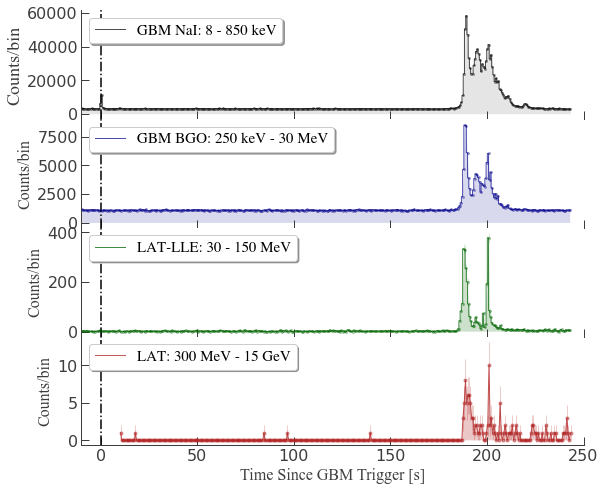

In [11]:
# Composite Light curve: GBM + LAT-LLE + LAT 
fig_all_lc, (ax1a, ax1a_b, ax2a, ax3a) = plt.subplots(4, sharex=True, sharey=False, figsize=(9,8))  
plt.rc('text', usetex=False)
plt.rc('font', family='times')
hfont = {'fontname':'Times New Roman'}

#  First subplot: NaI detectors 
ax1a.step(time_cts_1_8_850[2], Total_cts_nai_8_850, lw=1.0, color='k', alpha=0.7, label=r'GBM NaI: 8 - 850 keV')
ax1a.errorbar(time_cts_1_8_850[0], Total_cts_nai_8_850, yerr=np.sqrt(Total_cts_nai_8_850), 
              color ='black', fmt='o', ms='2.0', elinewidth=0.5, alpha=0.3)
ax1a.legend(shadow=True, numpoints=1, loc='upper left', fontsize=15)
ax1a.set_ylabel('Counts/bin', fontsize=18, **hfont)
ax1a.fill_between(time_cts_1_8_850[2], 0, Total_cts_nai_8_850, facecolor='k', alpha=0.1)
ax1a.set_xlim([-10, 280])
ax1a.locator_params(axis='y',tight=True, nbins=4)
ax1a.locator_params(axis='x',tight=True, nbins=10)
ax1a.tick_params(axis='both',which='both', width=1,direction='in')
ax1a.tick_params(which='major', length=8)
ax1a.tick_params(which='minor', length=4)
ax1a.tick_params(labelsize=15)
ax1a.tick_params(axis='x', labelsize=16)
ax1a.tick_params(axis='y', labelsize=16)
ax1a.axvline(0.0, color='k', linestyle='-.',lw='1.5')
#ax1a.axvline(start_g, color='grey', linestyle=':',lw='1.5')
#ax1a.axvline(stop_g, color='grey', linestyle=':',lw='1.5')
#plt.title(GRBname[grb_no], fontsize=18)

#Second subplot: BGO detector
ax1a_b.step(bgo_lc[0], bgo_lc[1], linewidth=1.0,color='darkblue', alpha=0.7, label=r'GBM BGO: 250 keV - 30 MeV')
ax1a_b.errorbar(bgo_lc[0], bgo_lc[1], yerr=np.sqrt(bgo_lc[1]), 
              color ='darkblue', fmt='o', ms='2.0', elinewidth=0.5, alpha=0.3)
ax1a_b.legend(shadow=True, numpoints=1, loc='upper left', fontsize=15)
ax1a_b.set_ylabel('Counts/bin', fontsize=16, **hfont)
ax1a_b.fill_between(bgo_lc[0], 0, bgo_lc[1], facecolor='darkblue', alpha=0.15)
ax1a_b.set_xlim([-10, 250])
ax1a_b.locator_params(axis='y',tight=True, nbins=4)
ax1a_b.locator_params(axis='x',tight=True, nbins=10)
ax1a_b.tick_params(axis='both',which='both', width=1,direction='in')
ax1a_b.tick_params(which='major', length=8)
ax1a_b.tick_params(which='minor', length=4)
ax1a_b.tick_params(labelsize=15)
ax1a_b.tick_params(axis='x', labelsize=16)
ax1a_b.tick_params(axis='y', labelsize=16)
ax1a_b.axvline(0.0, color='k', linestyle='-.',lw='1.5')

#Third subplot: LLE detector
ax2a.step(lle_lc[0], lle_lc[1], linewidth=1.0,color='darkgreen', alpha=0.75, label=r'LAT-LLE: 30 - 150 MeV')
ax2a.errorbar(lle_lc[0], lle_lc[1], yerr=np.sqrt(lle_lc[1]), 
              color ='darkgreen', fmt='o', ms='2.0', elinewidth=0.5, alpha=0.3)
ax2a.legend(shadow=True, numpoints=1, loc='upper left', fontsize=15)
ax2a.set_ylabel('Counts/bin', fontsize=16, **hfont)
ax2a.fill_between(lle_lc[0], 0, lle_lc[1], facecolor='darkgreen', alpha=0.2)
ax2a.set_xlim([-10, 250])
ax2a.locator_params(axis='y',tight=True, nbins=4)
ax2a.locator_params(axis='x',tight=True, nbins=10)
ax2a.tick_params(axis='both',which='both', width=1,direction='in')
ax2a.tick_params(which='major', length=8)
ax2a.tick_params(which='minor', length=4)
ax2a.tick_params(labelsize=15)
ax2a.tick_params(axis='x', labelsize=16)
ax2a.tick_params(axis='y', labelsize=16)
ax2a.axvline(0.0, color='k', linestyle='-.',lw='1.5')

#Third subplot: LAT detector
ax3a.plot(lat_lc[0], lat_lc[1],linewidth=1.0, color='firebrick', alpha=0.75, label=r'LAT: 300 MeV - 15 GeV')
ax3a.errorbar(lat_lc[0], lat_lc[1], yerr=np.sqrt(lat_lc[1]), 
              color ='firebrick', fmt='o', ms='3.0', elinewidth=0.5, alpha=0.45)
ax3a.legend(shadow=True, numpoints=1, loc='upper left', fontsize=15)
ax3a.set_ylabel('Counts/bin', fontsize=16, **hfont)
ax3a.set_xlim([-10, 250])
ax3a.fill_between(lat_lc[0], 0, lat_lc[1], facecolor='firebrick', alpha=0.25)
#ax3a.locator_params(axis='y',tight=True, nbins=3)
#ax3a.locator_params(axis='x',tight=True, nbins=10)
ax3a.tick_params(axis='both',which='both', width=1,direction='in')
ax3a.tick_params(which='major', length=8)
ax3a.tick_params(which='minor', length=4)
ax3a.tick_params(labelsize=15)
ax3a.tick_params(axis='x', labelsize=16)
ax3a.tick_params(axis='y', labelsize=16)
ax3a.axvline(0.0, color='k', linestyle='-.',lw='1.5')
ax3a.set_xlabel('Time Since GBM Trigger [s]',fontsize=16,**hfont)

fig_all_lc.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig_all_lc.axes[:-1]], visible=True)
#fig_all_lc.savefig(Trig_name+'_Fermi_lightcurve.pdf', bbox_inches='tight')
plt.show()


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarning: invalid value encountered in double_scalars


WARNING RuntimeWarn

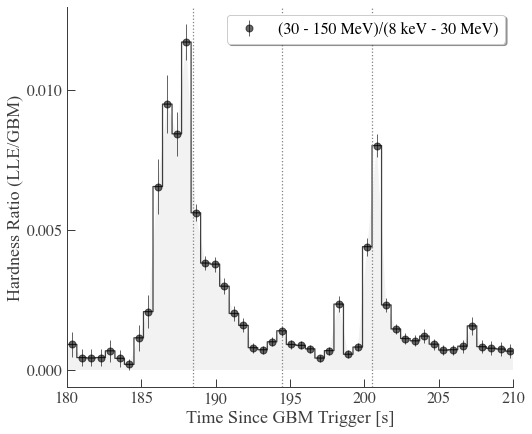

In [12]:
def HR_error(Total_cts_low, Total_cts_high):
    HR_gbm = []
    HR_gbm_err = []            
    for i in range(len(Total_cts_low)):
        HR = Total_cts_high[i]/float(Total_cts_low[i])
        HR_gbm.append(HR)
        error = np.sqrt(HR**2.0 * ((np.sqrt(Total_cts_high[i])/float(Total_cts_high[i]))**2.0 + (np.sqrt(Total_cts_low[i])/float(Total_cts_low[i])**2.0))  )
        HR_gbm_err.append(error)
    return [HR_gbm, HR_gbm_err]

gbm_counts = np.add(Total_cts_nai_8_850, bgo_lc[1])
    
HR_gbm_lle = HR_error(gbm_counts, lle_lc[1])[0]
HR_gbm_lle_err = HR_error(gbm_counts, lle_lc[1])[1]

fig_hr, (ax1a) = plt.subplots(1, sharex=True, sharey=False,figsize=(8,7))  
plt.rc('text', usetex=False)
plt.rc('font', family='times')
hfont = {'fontname':'Times New Roman'}

#fig.suptitle(GRB_name, fontsize=18)
ax1a.step(time_cts_1_8_850[2], HR_gbm_lle, lw=1.25, color='k', alpha=0.75)
ax1a.errorbar(time_cts_1_8_850[0], HR_gbm_lle, yerr=HR_gbm_lle_err, fmt='ko', ms=7.0, elinewidth=1.0, alpha=0.6, label=r'(30 - 150 MeV)/(8 keV - 30 MeV)')
ax1a.legend(shadow=True, numpoints=1, loc='upper right', fontsize=16)
ax1a.fill_between(time_cts_1_8_850[0], 0, HR_gbm_lle, facecolor='k', alpha=0.05)
ax1a.set_xlim([180, 210])
ax1a.locator_params(axis='y',tight=True, nbins=4)
ax1a.locator_params(axis='x',tight=True, nbins=10)
ax1a.tick_params(axis='both',which='both', width=1, direction='in')
ax1a.tick_params(which='major', length=8)
ax1a.tick_params(which='minor', length=4)
ax1a.tick_params(labelsize=15)
ax1a.tick_params(axis='x', labelsize=16)
ax1a.tick_params(axis='y', labelsize=16)
ax1a.axvline(188.5, color='grey', linestyle=':',lw='1.25')
ax1a.axvline(194.5, color='grey', linestyle=':',lw='1.25')
ax1a.axvline(200.5, color='grey', linestyle=':',lw='1.25')
ax1a.set_ylabel('Hardness Ratio (LLE/GBM)',fontsize=18, **hfont)
ax1a.set_xlabel('Time Since GBM Trigger [s]',fontsize=18,**hfont)

fig_hr.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig_hr.axes[:-1]], visible=True)
#fig_hr.savefig(Trig_name+'_HR_LLE_GBM.pdf')

plt.show()

# 3ML Time-series and Spectral Plugins


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2260 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_06 background:   0%|          | 0/128 [00:00<?, ?it/s]

,0
n. channels,128
total rate,4550.707169
total bkg. rate,1088.704297
total bkg. rate error,21.895859
bkg. exposure,69.34197
bkg. is poisson,False
exposure,69.34197
is poisson,True
background,profiled
significance,148.805403



WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2260 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_07 background:   0%|          | 0/128 [00:00<?, ?it/s]

,0
n. channels,128
total rate,3882.898246
total bkg. rate,1133.784059
total bkg. rate error,3.224656
bkg. exposure,69.416962
bkg. is poisson,False
exposure,69.416962
is poisson,True
background,profiled
significance,407.983952



WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2260 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_09 background:   0%|          | 0/128 [00:00<?, ?it/s]

,0
n. channels,128
total rate,4018.180488
total bkg. rate,1170.618989
total bkg. rate error,3.334426
bkg. exposure,69.41948
bkg. is poisson,False
exposure,69.41948
is poisson,True
background,profiled
significance,413.231092



WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING RuntimeWarning: invalid value encountered in true_divide



Loading PHAII Spectra:   0%|          | 0/2260 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in true_divide


WARNING RuntimeWarning: invalid value encountered in true_divide



Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_BGO_01 background:   0%|          | 0/128 [00:00<?, ?it/s]

,0
n. channels,128
total rate,4754.330949
total bkg. rate,2145.894688
total bkg. rate error,4.390911
bkg. exposure,69.301444
bkg. is poisson,False
exposure,69.301444
is poisson,True
background,profiled
significance,312.948657


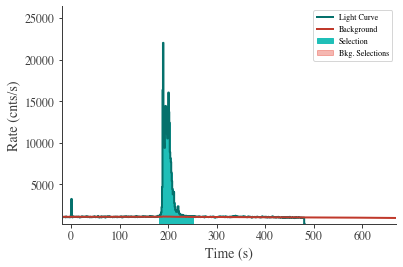

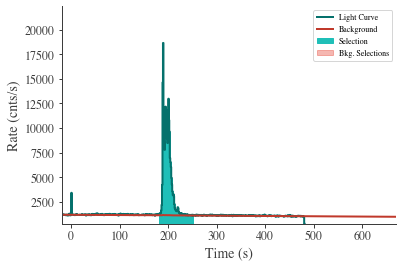

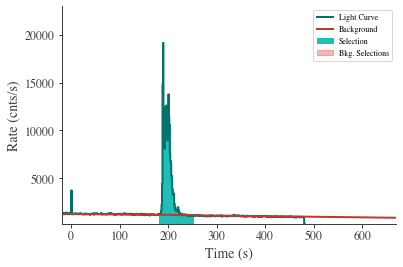

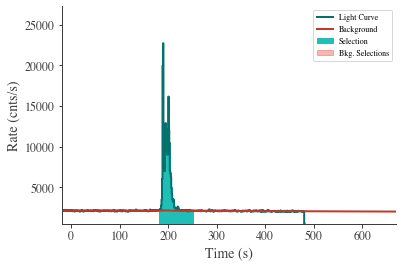

In [174]:
source_interval= "180.000000-250.000000"

# Building plugins from GBM
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(str(source_interval))

    ts_tte.view_lightcurve(-20, 670)

    fluence_plugin = ts_tte.to_spectrumlike()
    
    fluence_plugin.display()  # For significance in each detector

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("300-30000")

    else:

        fluence_plugin.set_active_measurements("8-30","40-850")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)


Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GLAST_LLE background:   0%|          | 0/50 [00:00<?, ?it/s]

,0
n. channels,50
total rate,129.672317
total bkg. rate,8.744165
total bkg. rate error,1.73081
bkg. exposure,63.999782
bkg. is poisson,False
exposure,63.999782
is poisson,True
background,profiled
significance,56.450745


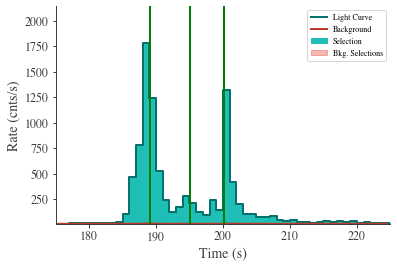

In [270]:
# Building plugins from LAT-LLE
lle_file = event_filename_lle
ft2_file = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/gll_pt_'+Trig_name+'_v00.fit'))
lle_rsp = ''.join(glob.glob('/Users/dove/Desktop/Synchrotron_Model_Test/GRB160625B/bn160625945/gll_cspec_lle_'+Trig_name+'_v00.rsp'))

lat_lle = TimeSeriesBuilder.from_lat_lle('lat_lle',
                                        lle_file=lle_file,
                                        ft2_file=ft2_file,
                                        rsp_file=lle_rsp)

#selecting source intervals
lat_lle.set_active_time_interval(str(source_interval))

#Fitting a polynomial background
lat_lle.set_background_interval('-87.0--22.0','817.0-890.0', unbinned=False)   #-87.500000--22.500000,817.500000-890.000000

#Saving the background fit
lat_lle.save_background('background_store',overwrite=True)

fig = lat_lle.view_lightcurve(start=175, stop=225);
_ = plt.axvline(x=189.1, color='g')
_ = plt.axvline(x=195.1, color='g')
_ = plt.axvline(x=200.2, color='g')

lle_plugin = lat_lle.to_spectrumlike()
lle_plugin.display()

# Time Resolved Analysis

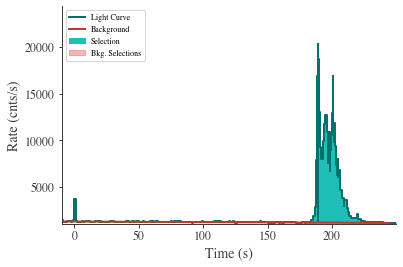

In [16]:
#Selecting a temporal binning
nai = time_series["n9"]

nai.create_time_bins(180.0, 250.0, method="bayesblocks", use_background=True, p0=0.1)
#nai.create_time_bins(180.0, 250.0, method="significance", sigma=25.0)

fig = nai.view_lightcurve(use_binner=True)

,Start,Stop,Duration,Midpoint
0,180.000436,183.840099,3.839663,181.920268
1,183.840099,185.609270,1.769171,184.724685
2,185.609270,186.444097,0.834827,186.026684
3,186.444097,186.842197,0.398100,186.643147
4,186.842197,187.259692,0.417495,187.050945
5,187.259692,187.675444,0.415752,187.467568
6,187.675444,187.922195,0.246751,187.798819
7,187.922195,188.153160,0.230965,188.037677
8,188.153160,188.299299,0.146139,188.226230
9,188.299299,188.487492,0.188193,188.393396


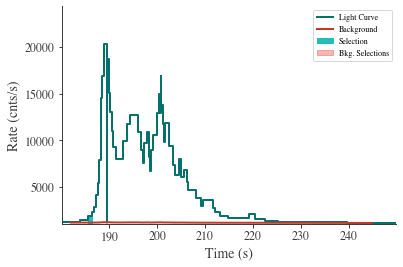

In [176]:
bad_bins = []
for i, w in enumerate(nai.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)

edges = [nai.bins.starts[0]]

for i, b in enumerate(nai.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]
#print(starts[0], stops[0])
nai.bins.display()

fig = nai.view_lightcurve(180.0, 250.0, use_binner=True)
fig.savefig(Trig_name+'_BB_lc.pdf')

In [262]:
#s_int= str(starts[2])+'-'+str(stops[2])
#nai.set_active_time_interval(s_int)
check_plugin = nai.to_spectrumlike(from_bins=True)

Creating plugins:   0%|          | 0/59 [00:00<?, ?it/s]

In [269]:
#check_plugin[0].display()
#import pandas as pd
#df = pd.DataFrame(check_plugin[0])
#sig = df.values[1]

from threeML.utils.statistics.stats_tools import Significance
#===== Store in a file =======
file_s = open(Trig_name+'_Each_Interval_Significance.txt', 'a')
file_s.write('Interval    Start        Stop        Midpoint        Significance' + '\n')

for j in range(len(starts)):
    mid_p = (starts[j]+stops[j])/2.
    total_counts = nai._time_series.counts_over_interval(starts[j], stops[j])
    bkg_counts = nai._time_series.get_total_poly_count(starts[j], stops[j])
    bkg_error = nai._time_series.get_total_poly_error(starts[j], stops[j])
    sig_calc = Significance(total_counts, bkg_counts)
    sig_val = sig_calc.li_and_ma_equivalent_for_gaussian_background(bkg_error)[0]
    file_s.write('%d' %j + '\t %2.4f' %starts[j] + '\t %2.4f' %stops[j] + '\t %2.4f' %mid_p + '\t %2.2f' %sig_val +'\n')
file_s.close()

In [272]:
#===== Store in a file =======
file_l = open(Trig_name+'_Each_Interval_Significance_LLE.txt', 'a')
file_l.write('Interval    Start        Stop        Midpoint        Significance' + '\n')

for j in range(len(starts)):
    mid_p = (starts[j]+stops[j])/2.
    total_counts = lat_lle._time_series.counts_over_interval(starts[j], stops[j])
    bkg_counts = lat_lle._time_series.get_total_poly_count(starts[j], stops[j])
    bkg_error = lat_lle._time_series.get_total_poly_error(starts[j], stops[j])
    sig_calc = Significance(total_counts, bkg_counts)
    sig_val = sig_calc.li_and_ma_equivalent_for_gaussian_background(bkg_error)[0]
    file_l.write('%d' %j + '\t %2.4f' %starts[j] + '\t %2.4f' %stops[j] + '\t %2.4f' %mid_p + '\t %2.2f' %sig_val +'\n')
file_l.close()

# Writing as PHAII file for analysis

In [17]:
#Selecting a temporal binning
nai.create_time_bins(start = starts, stop = stops, method="custom")
nai.write_pha_from_binner(file_name='Fermi_GBM_nai_bright', overwrite=True,
                              force_rsp_write = True)  # if you need to write the RSP to a file. We try to choose the best option for you.

nai_2 = time_series['n6']
nai_2.create_time_bins(start = starts, stop = stops, method="custom")
nai_2.write_pha_from_binner(file_name='Fermi_GBM_nai_2', overwrite=True,
                              force_rsp_write = True)  

nai_3 = time_series['n7']
nai_3.create_time_bins(start = starts, stop = stops, method="custom")
nai_3.write_pha_from_binner(file_name='Fermi_GBM_nai_3', overwrite=True,
                              force_rsp_write = True)  

nai_b = time_series['b1']
nai_b.create_time_bins(start = starts, stop = stops, method="custom")
nai_b.write_pha_from_binner(file_name='Fermi_GBM_bgo_1', overwrite=True,
                              force_rsp_write = True)  

#Selecting a temporal binning
lat_lle.create_time_bins(start = starts, stop = stops, method='custom')
lat_lle.write_pha_from_binner(file_name='Fermi_LAT_lle', overwrite=True,
                              force_rsp_write = True)  # if you need to write the RSP to a file. We try to choose the best option for you.

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

In [20]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(nai)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)
    
lle_plugins = lat_lle.to_spectrumlike(from_bins=True)

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/57 [00:00<?, ?it/s]